## Data Visualization 

In [1]:
#Imports 

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import LSTM, SimpleRNN, Input
from keras.layers import Dense
from datetime import datetime
import seaborn as sns
from sklearn.metrics import mean_squared_error 
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# Loading the collected data into a dataframe

df = pd.read_csv('SU.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-03-17,0.0,0.117188,0.085938,0.085938,0.043638,86400
1,1980-03-18,0.0,0.117188,0.085938,0.085938,0.043638,43200
2,1980-03-19,0.0,0.117188,0.085938,0.085938,0.043638,97600
3,1980-03-20,0.0,0.125000,0.093750,0.093750,0.047604,65600
4,1980-03-21,0.0,0.125000,0.093750,0.093750,0.047604,64000


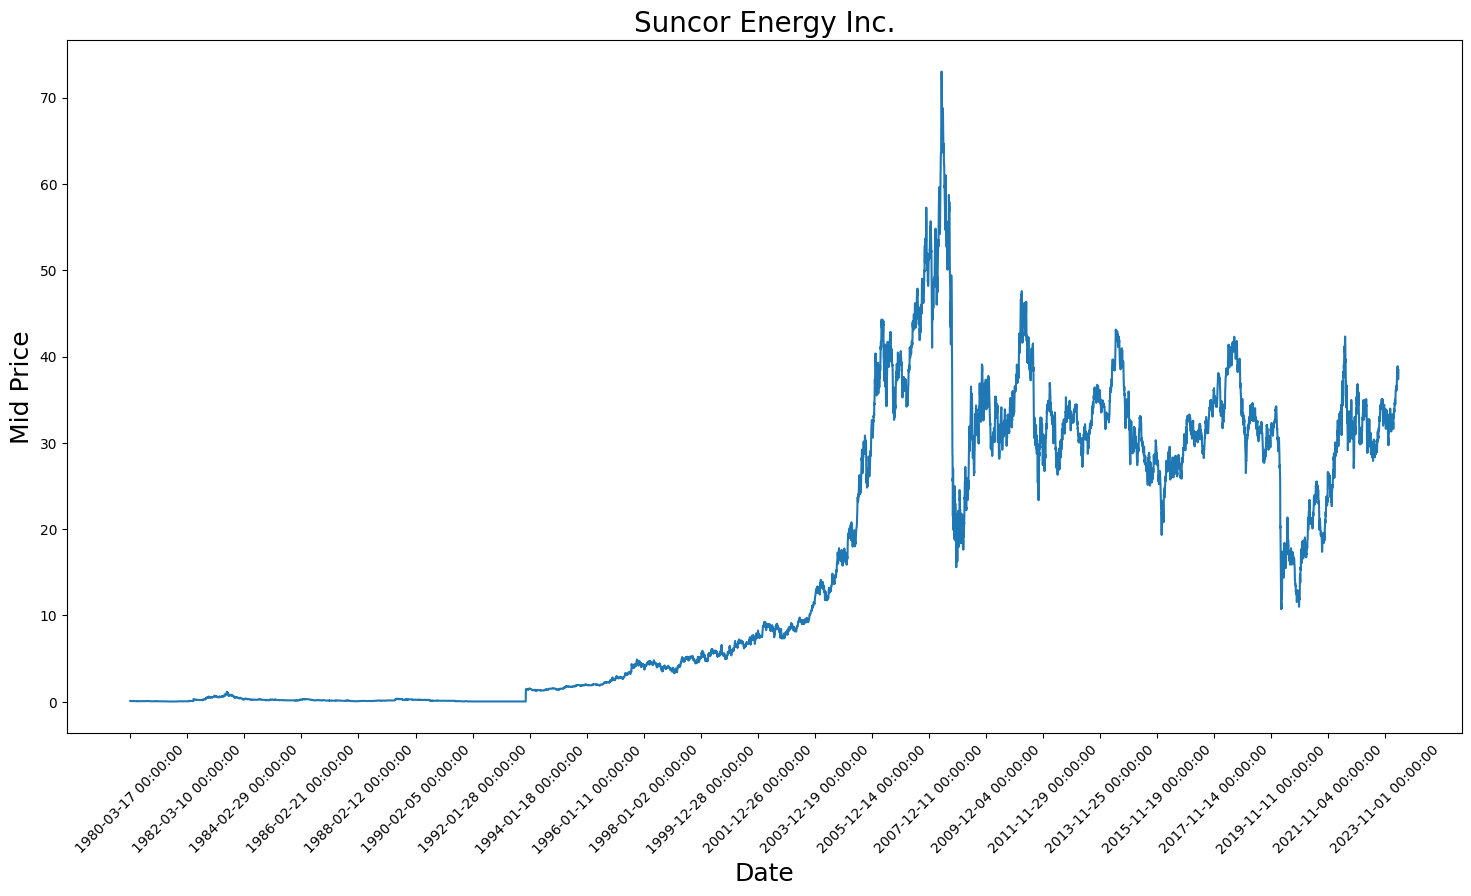

In [3]:
# Plotting a graph of the data

plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.title('Suncor Energy Inc.', fontsize=20)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

## Data Preprocessing 

In [4]:
# Creating a function that plots the train/test split by year

def plot_train_test_data(dataset, start_year, end_year, target_column):

    dataset['Year'] = dataset['Date'].dt.year
    train = dataset[(dataset['Year'] >= start_year) & (dataset['Year'] <= end_year)]
    test = dataset[dataset['Year'] > end_year]

    plt.figure(figsize=(18,9))
    plt.plot(train['Date'], train[target_column], color='blue', label=f'Train (Before {end_year+1})')
    plt.plot(test['Date'], test[target_column], color='red', label=f'Test ({end_year+1} and beyond)')
    plt.xlabel('Date')
    plt.ylabel(target_column)
    plt.legend()
    plt.show()

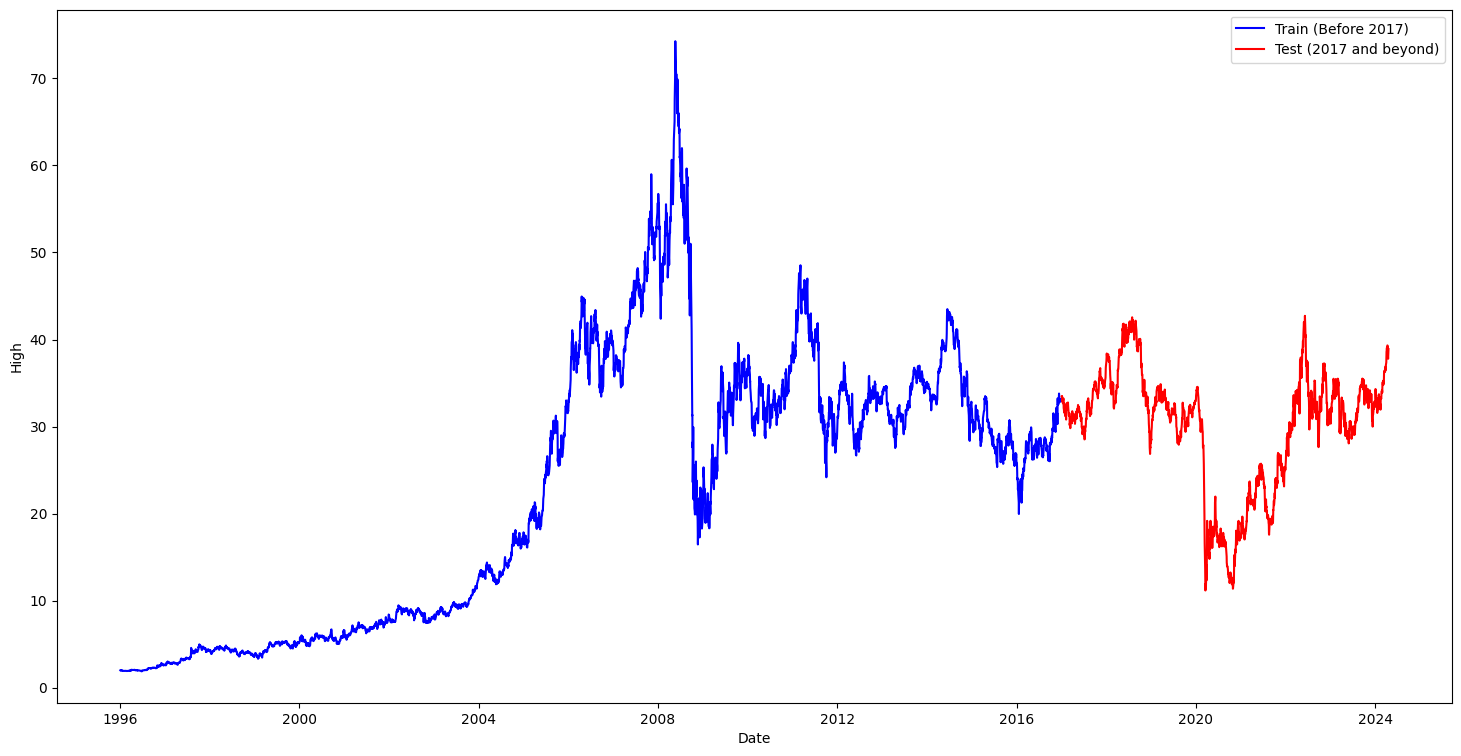

In [5]:
plot_train_test_data(df, 1996, 2016, 'High')

In [6]:
# Creating train/test split function

def train_test_split(dataset, start_year, end_year, target_column):
    
    dataset['Year'] = dataset['Date'].dt.year

    train = dataset[(dataset['Year'] >= start_year) & (dataset['Year'] <= end_year)][target_column]
    test = dataset[dataset['Year'] > end_year][target_column]

    return train, test

In [7]:
training_set, test_set = train_test_split(df, 1996, 2016, 'High')

In [8]:
# Scaling the data

sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.values.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

## Recurrent Neural Network Model

### Creating overlaping batches



In [9]:
n_steps = 1
features = 1

In [10]:
def split_sequence(sequence, n_steps):
    
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [11]:
X_train, y_train = split_sequence(training_set_scaled, n_steps)

In [12]:
# Reshaping X_train for model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], features)

###  RNN

In [13]:
model_rnn = Sequential()
model_rnn.add(Input(shape=(n_steps, features)))  # Use an Input layer to define the input shape
model_rnn.add(SimpleRNN(units=125))
model_rnn.add(Dense(units=1))

In [14]:
# Compiling the model
model_rnn.compile(optimizer="RMSprop", loss="mse")

In [15]:
# Function that will plot the loss as it evolves through the epochs

def plot_loss(history):
    
    plt.figure(figsize = (15,10))
    plt.plot(history.history['loss'], label='loss')
    plt.legend(loc='best')
    plt.show()

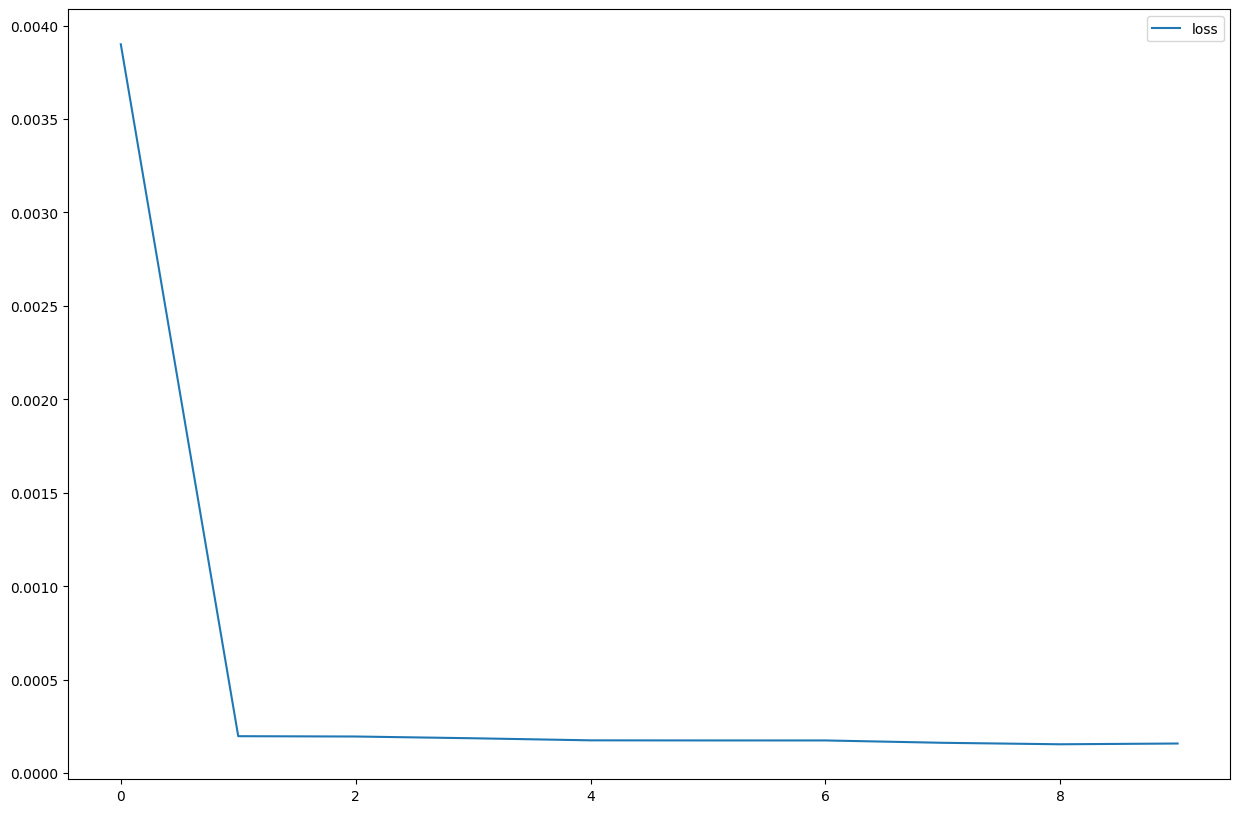

In [16]:
history = model_rnn.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

plot_loss(history)

### Time Series Prediction using RNN

In [17]:
# Scaling
inputs = sc.transform(test_set.values.reshape(-1, 1))

In [18]:
# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)
# reshape
X_test = X_test.reshape(-1, n_steps, features)

In [19]:
# Prediction
predicted_stock_price = model_rnn.predict(X_test)
# Inverse transform the values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [20]:
def plot_predictions(test, predicted, title):

    # Ensure that both 'test' and 'predicted' have the same length
    min_length = min(len(test), len(predicted))
    test = test[:min_length]
    predicted = predicted[:min_length]
    
    time_steps = range(len(test))
    
    plt.plot(time_steps, test, color="gray", label="Real")  # Set alpha for transparency
    plt.plot(time_steps, predicted, color="red", label="Predicted")  # Set alpha for transparency
    plt.xlabel("Time")
    plt.ylabel(f'{title}')
    plt.legend()
    plt.show()

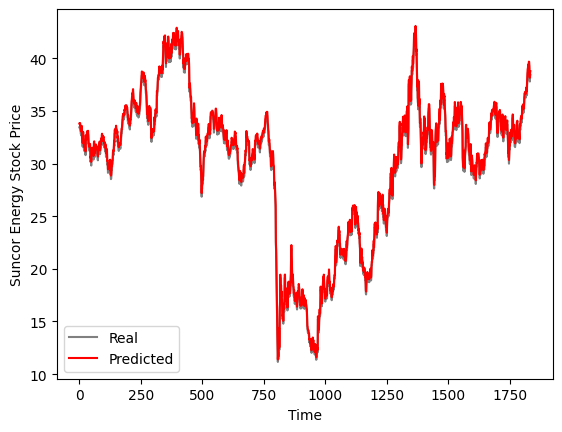

In [21]:
plot_predictions(test_set, predicted_stock_price, "Suncor Energy Stock Price")

### Sequence Generation using RNN

In [22]:
steps_in_future = 30

In [23]:
def sequence_generation(dataset: pd.DataFrame, sc: MinMaxScaler, model:Sequential, steps_future: int):
    high_dataset = dataset.iloc[len(dataset) - len(test_set) - n_steps:]["High"]
    high_dataset = sc.transform(high_dataset.values.reshape(-1, 1))
    inputs = high_dataset[:n_steps]

    for _ in range(steps_future):
        curr_pred = model.predict(inputs[-n_steps:].reshape(-1, n_steps, features), verbose=0)
        inputs = np.append(inputs, curr_pred, axis=0)

    return sc.inverse_transform(inputs[n_steps:])

In [24]:
results = sequence_generation(df, sc, model_rnn, steps_in_future)

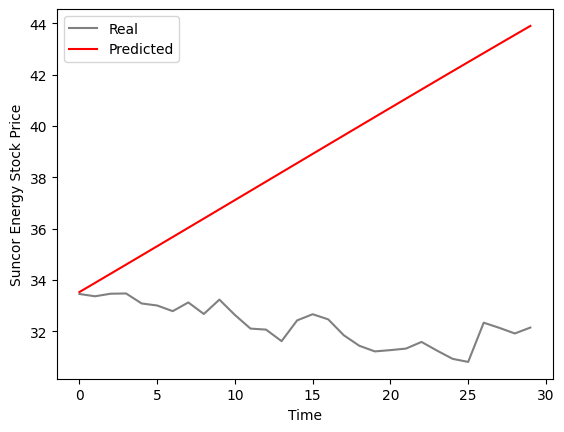

In [25]:
plot_predictions(test_set[:steps_in_future], results, "Suncor Energy Stock Price")

## Long Short Term Memory Model

In [26]:
model_lstm = Sequential()
model_lstm.add(Input(shape=(n_steps, features)))  # Use an Input layer to define the input shape
model_lstm.add(LSTM(units=150))
model_lstm.add(Dense(units=1))

In [27]:
# Compiling the model
model_lstm.compile(optimizer="RMSprop", loss="mse")

In [28]:
history = model_lstm.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

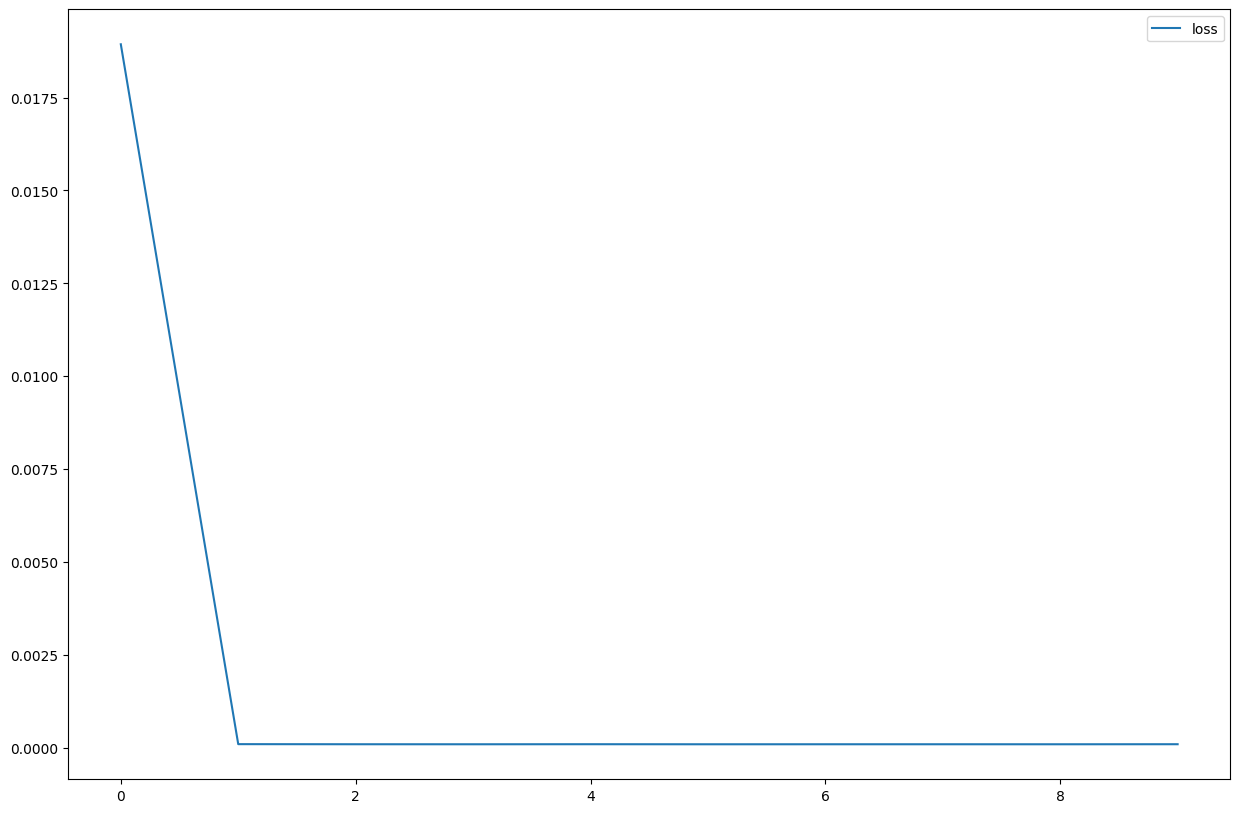

In [29]:
plot_loss(history)

In [30]:
#prediction
predicted_stock_price = model_lstm.predict(X_test)
#inverse transform the values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


### Time Series Prediction using LSTM

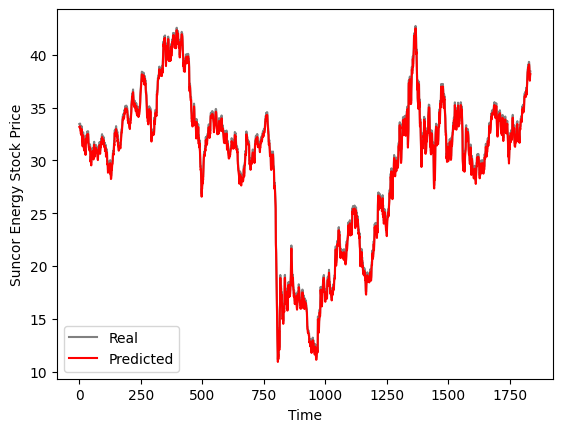

In [31]:
plot_predictions(test_set, predicted_stock_price, "Suncor Energy Stock Price")

### Sequence Generation using LSTM

In [32]:
results = sequence_generation(df, sc, model_lstm, steps_in_future)

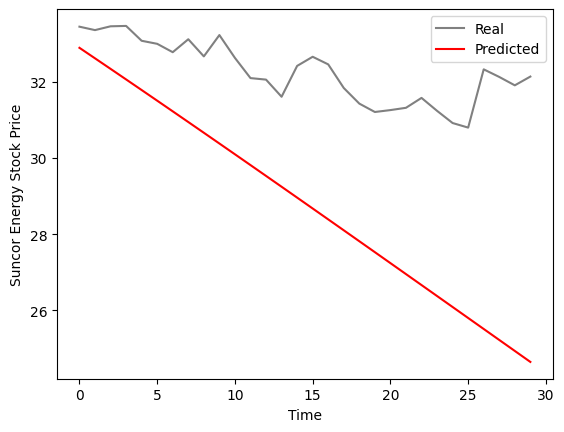

In [33]:
plot_predictions(test_set[:steps_in_future], results, "Suncor Energy Stock Price")